# Script to discriminate music and podcasts

Among all the files reported in the original .csv file there were many audio files conatining podcasts. For this reason I have used a CNN model to keep only the music files.

In [54]:
%pip install pydub

In [2]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.api._v2.keras.layers.experimental import preprocessing
from keras import layers
from keras import models
import tensorflow_datasets as tfds
import librosa as lib

In [56]:
#ds = tfds.load('GTZANMusicSpeech', split='train', shuffle_files=True)

In [3]:
#data_dir = pathlib.Path('/root/tensorflow_datasets/downloads/extracted/TAR_GZ.opihi.cs.uvic.ca_sound_music_speechbya81rFcWfLSW6ey5cynqyeq2qiePcL-7asMoNO6IQ0.tar.gz/music_speech')

data_dir = "c:\SpeechMusic"

In [4]:
categories = np.array(tf.io.gfile.listdir(str(data_dir)))
categories = [category for category in categories if 'wav' in category]

In [5]:
print(categories)

['music_wav', 'speech_wav']


In [6]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = [filename for filename in filenames if '_wav' in filename]
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
#print('Number of examples per label:',      len(tf.io.gfile.listdir(str(data_dir/categories[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 128
Example file tensor: tf.Tensor(b'c:\\SpeechMusic\\music_wav\\eguitar.wav', shape=(), dtype=string)


In [7]:
TRAIN_SIZE = 0.75

train_files = filenames[:int(len(filenames) * TRAIN_SIZE)]
val_files = filenames[int(len(filenames) * TRAIN_SIZE):]

print('Training set size:', len(train_files))
print('Validation set size:', len(val_files))

Training set size: 96
Validation set size: 32


In [14]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [13]:
def get_waveform_and_labelMP3(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    #waveform = decode_audio(audio_binary)
    return audio_binary, label

In [9]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

In [10]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary) # returns the WAV-encoded audio as a tensor and the sample rate
  return tf.squeeze(audio, axis=-1) # removes dimensions of size 1 from the last axis

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [16]:
def get_spectrogram(waveform):
    # produces an array of complex numbers representing magnitude and phase
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)

    # removes the phase (we only care about the magnitude)
    spectrogram = tf.abs(spectrogram)

    return spectrogram

In [17]:
for waveform, label in waveform_ds.take( 1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
# print('Audio playback')
# display.display(display.Audio(waveform, rate=16000))

Label: music_wav
Waveform shape: (661500,)
Spectrogram shape: (5166, 129)


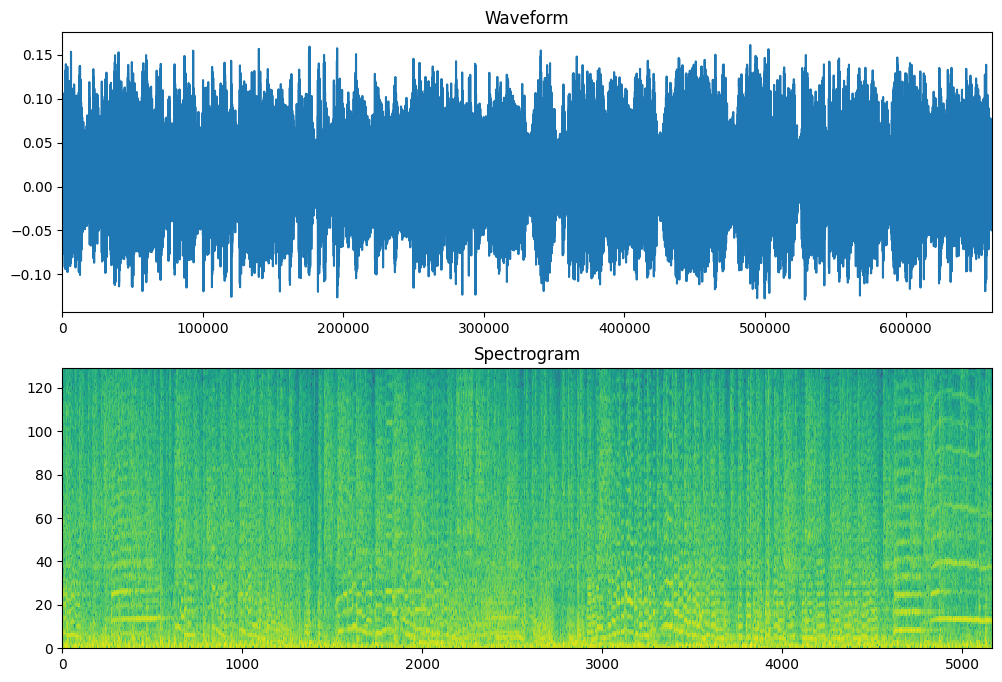

In [18]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  ax.pcolormesh(log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 661500])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [19]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == categories)
  return spectrogram, label_id

In [20]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

In [21]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [22]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)

In [23]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [24]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape

print('Input shape:', input_shape)
num_labels = len(categories)

Input shape: (5166, 129, 1)


In [25]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(64, 64), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation ='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 64, 64, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 64)        0

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [27]:
EPOCHS = 30
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/30


C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3/3 [==============================] - 56s 18s/step - loss: 1.4982 - accuracy: 0.5729 - val_loss: 1.2605 - val_accuracy: 0.5625
Epoch 2/30
3/3 [==============================] - 2s 744ms/step - loss: 0.9511 - accuracy: 0.5312 - val_loss: 0.7855 - val_accuracy: 0.6250
Epoch 3/30
3/3 [==============================] - 2s 559ms/step - loss: 0.5548 - accuracy: 0.6875 - val_loss: 0.4458 - val_accuracy: 0.8750
Epoch 4/30
3/3 [==============================] - 1s 473ms/step - loss: 0.3612 - accuracy: 0.8854 - val_loss: 0.4644 - val_accuracy: 0.7500
Epoch 5/30
3/3 [==============================] - 2s 573ms/step - loss: 0.3456 - accuracy: 0.8438 - val_loss: 0.3537 - val_accuracy: 0.8750
Epoch 6/30
3/3 [==============================] - 2s 611ms/step - loss: 0.2527 - accuracy: 0.9479 - val_loss: 0.2913 - val_accuracy: 0.9062
Epoch 7/30
3/3 [==============================] - 2s 589ms/step - loss: 0.1747 - accuracy: 0.9583 - val_loss: 0.2002 - val_accuracy: 0.9375
Epoch 8/30
3/3 [================

In [28]:
file_dir = "c:/Audio/"
#file_list = tf.io.gfile.glob(str(file_dir) + '/*/*')
file_list = os.listdir(str(file_dir))


In [29]:
print(len(file_list))

101939


In [30]:
print(file_list[0])

000RDCYioLteXcutOjeweY.mp3


In [37]:
outputFile = open("music_speech2.csv","w")
for index, file in enumerate(file_list[72893:]):
    audio, sr = lib.load(file_dir+file)
    spec = tf.signal.stft(audio, frame_length=255, frame_step=128)
    spec = tf.abs(spec)
    spec = tf.expand_dims(spec, -1)
    spec = tf.expand_dims(spec, 0)
    result = model.predict(spec)
    if result[0][0]>result[0][1]:
        result ="Music"
    else:
       result ="Speech"
    outputFile.write(str(72893+index)+","+file+","+result+"\n")


1/1 [==============================] - 0s 34ms/step


C:\Users\Utente\AppData\Local\Temp\ipykernel_10448\3883271979.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = lib.load(file_dir+file)
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


NoBackendError: 

(661501,)


C:\Users\Utente\AppData\Local\Temp\ipykernel_10380\2889863213.py:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


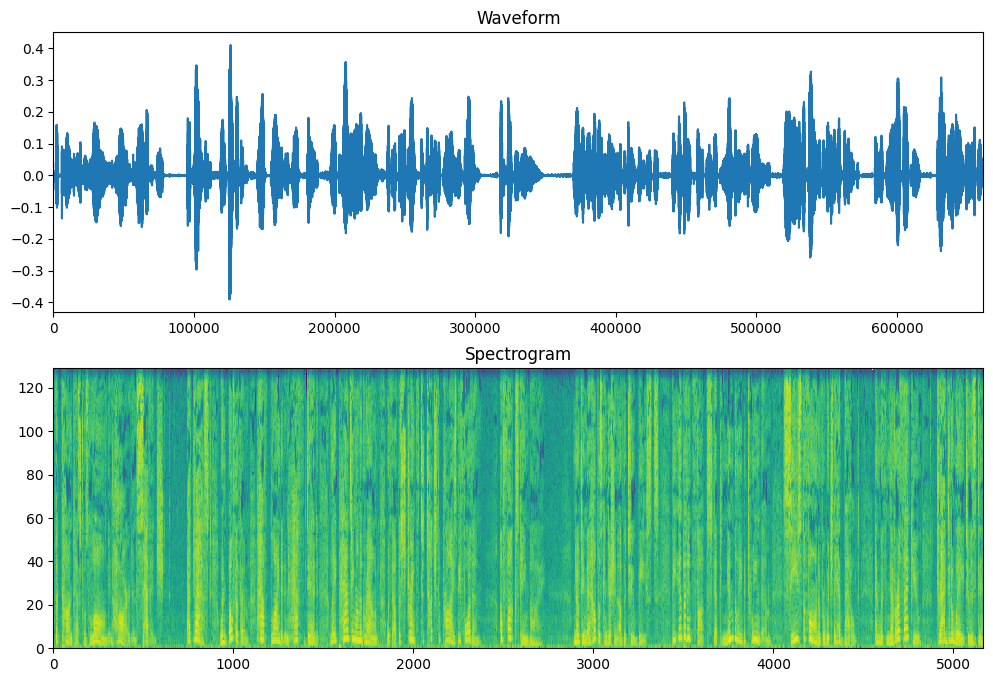

(5166, 129)
(1, 5166, 129, 1)
1/1 [==============================] - 0s 327ms/step
[[0.5424312  0.45756882]] --> Music


In [83]:

#audio, sr = lib.load(str(file_dir)+"/"+file_list[6])
audio, _ = lib.load(str(file_dir)+"/"+"0FeShNH5UiZ98CgUTbn0EH.mp3")
#audio = tf.io.read_file(str(file_dir)+"/"+file_list[10])
#print(audio)
#audio, _ = lib.load("C:\SpeechMusic\music_wav\gravity.wav")
print(audio.shape)
spec = tf.signal.stft(audio, frame_length=255, frame_step=128)
spec=tf.abs(spec)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(audio.shape[0])
axes[0].plot(timescale, audio)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 661500])
plot_spectrogram(spec.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

print(spec.shape)
spec = tf.expand_dims(spec, -1)
spec = tf.expand_dims(spec, 0)
print(spec.shape)
result = model.predict(spec)

if result[0][0]>result[0][1]:
    print(result, "--> Music")
else:
    print(result, "--> Speech")
